# Task 2

### Global setup, reading in the dataset and checking it has been read in correctly

In [1]:
import pandas as pd
import numpy as np

# Function to load the training and test datasets
# Returns data in the format x_train, y_train, x_test, y_test
def load_dataset():
    train_df = pd.read_csv('traindrug.csv')
    test_df = pd.read_csv('testdrug.csv')

    x_train =  np.asarray(train_df.values[:, 0])
    y_train =  np.asarray(train_df.values[:, 1]).astype(np.int32)
    x_test =  np.asarray(test_df.values[:, 0])
    y_test = np.asarray(test_df.values[:, 1]).astype(np.int32)

    return x_train, y_train, x_test, y_test

In [2]:
x_train, y_train, x_test, y_test = load_dataset()

# Confirming expected data sizes
print("Length: x_train:", len(x_train))
print("Length: y_train:", len(y_train))
print("Length: x_test:", len(x_test))
print("Length: y_test:", len(y_test))

assert len(x_train) == 1000
assert len(y_train) == 1000
assert len(x_test) == 500
assert len(y_test) == 500

Length: x_train: 1000
Length: y_train: 1000
Length: x_test: 500
Length: y_test: 500


### Task 2.1 CNN as chosen model

In [3]:
# Convert glove text to word2vec format if it doesn't already exist
# This takes some time
from os.path import exists
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_file = 'glove.6B.300d.txt.word2vec'

if not exists(word2vec_file):
    print("Creating file in glove format")
    glove2word2vec(glove_input_file, word2vec_file)

from gensim.models import KeyedVectors
glove_vectors = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

# Setup tokenizer and fit to training data
# Imports for converting data to tokenized integers for embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)

number_of_words = len(tokenizer.word_index) + 1

# Determine the max word count in a sample in x_train
sentence_word_counts = []
for x in x_train:
    sentence_word_counts.append(len(x.split()))
max_word_count = max(sentence_word_counts) + 10 # Adding more if max_word_count in test is larger 
print("Maximum words in a sentence in x_train:", max_word_count)

# Pad all sequences to the same length
x_train_seq = pad_sequences(sequences=train_sequences, maxlen=max_word_count)

# Also create and pad the sequence for test data
test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences=test_sequences, maxlen=max_word_count)

# Lastly convert all sequences to a numpy float array
x_train_seq = np.asarray(x_train_seq).astype(np.float32)
x_test_seq = np.asarray(x_test_seq).astype(np.float32)

print("Glove loaded and sequences generated for x_train and x_test")

Maximum words in a sentence in x_train: 310
Glove loaded and sequences generated for x_train and x_test


In [4]:
# Define weight matrix for embedding and populate with glove vector at for each word
embedded_weight_matrix = np.zeros((number_of_words, 300))

for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_vector = glove_vectors[word]
        embedded_weight_matrix[i] = embedding_vector

# Test the matrix compare word at index 0
print(embedded_weight_matrix.shape)
# First tokenized word is 'i'
print(np.array_equal(embedded_weight_matrix[1], glove_vectors['i']))

(5626, 300)
True


### Convolutional Neural Network Model

In [35]:
import matplotlib.pyplot as plt 
def plot_confusion_matrix(confusion_matrix, labels, plot_title=""):
    """
    Plots a confusion matrix for a given range of class labels 
    """
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.matshow(confusion_matrix, cmap='Blues')
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)

    for (x, y), value in np.ndenumerate(confusion_matrix):
                plt.text(y, x, f"{value:.2f}", va="center", ha="center")


    plt.title(plot_title)
    plt.xlabel("Predicted Class")
    plt.ylabel("Class")
    plt.show()

In [ ]:
# Decimal to integer labels
def prediction_decimal_values_to_class_values(y_pred):
    """
    Converts predicted regression values to class labels (1,2,3)
    via clipping and rounding
    """
    y_pred[y_pred < 1.0] = 1
    y_pred[y_pred > 3.0] = 3

    # Rounds values in between to an integer
    y_pred = np.round(y_pred)
    
    # Return as integers
    return y_pred.astype(np.int32)


In [30]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

# Define a CNN model using embedding
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=number_of_words, output_dim=300, weights=[embedded_weight_matrix], input_length=max_word_count, trainable=False))
cnn_model.add(Conv1D(filters=200, kernel_size=2, padding='valid', activation='relu', strides=1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1, kernel_initializer='random_uniform', bias_initializer='zeros'))

opt = Adam(learning_rate=0.002)

cnn_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['accuracy'])

# Run the model against the computed vectors
epochs = 100
history = cnn_model.fit(x_train_seq, y_train, epochs=epochs, batch_size=32, verbose=0, validation_data=(x_test_seq, y_test))

print("CNN training complete")

CNN training complete


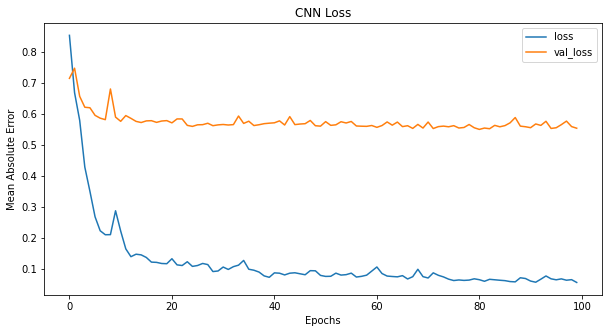

Confusion matrix: 
[[ 70  91   3]
 [ 32 117  16]
 [  8 102  61]]


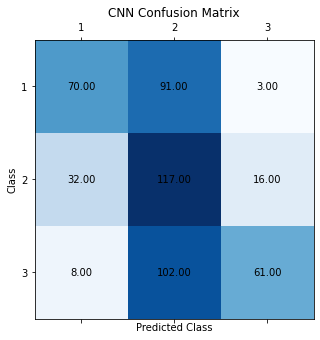

In [36]:
# Evaluate trained CNN model
y_pred = cnn_model.predict(x_test_seq)

y_pred = prediction_decimal_values_to_class_values(y_pred)

# Loss curve
plot_loss_curve(history, "CNN Loss")

# Confusion Matrix
cnn_confusion_matrix = confusion_matrix(y_test, y_pred)

print("Confusion matrix: ")
print(cnn_confusion_matrix)
plot_confusion_matrix(cnn_confusion_matrix, labels=[1,2,3], plot_title="CNN Confusion Matrix")